In [221]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [222]:
global_rng = np.random.default_rng(42)

In [223]:
# # Data from pre-VSS experiment
# df = pd.read_csv('crowdingReadingAcuity_dec24_cleaned.csv').iloc[:,1:]
# df['crowding_L5_var'] = np.var(df[['crowding_L5_test', 'crowding_L5_retest']], axis=1)
# df['crowding_R5_var'] = np.var(df[['crowding_R5_test', 'crowding_R5_retest']], axis=1)

In [ ]:
def construct_cov_mtx(var_x: float, var_y: float, rho: float) -> np.ndarray:
    cov_xy = rho * np.sqrt(var_x * var_y)
    return np.array([[var_x, cov_xy],
                     [cov_xy, var_y]])


def simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points, rng=global_rng):
    if rng is None:
        rng = np.random.default_rng()
    cov = construct_cov_mtx(var_x, var_y, rho)
    data = rng.multivariate_normal([mu_x, mu_y], cov, size=n_points)
    x, y = data[:, 0], data[:, 1]
    return x, y

def add_gaussian_noise(x, y, noise_var, m=0, rng=global_rng):
    if rng is None:
        rng = np.random.default_rng()
    sd = np.sqrt(noise_var * m)
    x_noisy = x + rng.normal(0, sd, size=x.shape)
    y_noisy = y + rng.normal(0, sd, size=y.shape)
    return x_noisy, y_noisy



In [225]:
def tls_regression(x_vals, y_vals):
    """Compute Total Least Squares (orthogonal) regression slope and intercept."""
    x_mean, y_mean = x_vals.mean(), y_vals.mean()
    Sxx = np.sum((x_vals - x_mean)**2)
    Syy = np.sum((y_vals - y_mean)**2)
    Sxy = np.sum((x_vals - x_mean)*(y_vals - y_mean))
    # TLS slope formula
    slope = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*Sxy**2)) / (2*Sxy)
    intercept = y_mean - slope * x_mean
    return slope, intercept

In [226]:
def plot_scatter_with_tls(
    x, y,
    rho=None,                      # for annotation
    ax=None,
    xlim=(-0.3, 0.9),
    ylim=(2, 4),
    xtick_step=0.3,
    ytick_step=0.5,
    xlabel='Variable X',
    ylabel='Variable Y',
    point_size=90,
    alpha=0.6,
    line_n=200,
    line_label='TLS fit',
    annotate=True,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    slope, intercept = tls_regression(x, y)
    r_value, _ = pearsonr(x, y)

    ax.scatter(x, y, s=point_size, alpha=alpha)

    # Draw fitted line over the visible x-range
    x_line = np.linspace(xlim[0], xlim[1], line_n)
    ax.plot(x_line, slope * x_line + intercept, linewidth=2, label=line_label)

    if annotate:
        if rho is not None:
            ax.text(0.05, 0.97, rf'$\rho = {rho}$',
                    transform=ax.transAxes, va='top', fontsize=22, color='black')
        ax.text(0.05, 0.89, rf'$r = {r_value:.2f}$',
                transform=ax.transAxes, va='top', fontsize=22, color='red')

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)

    ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
    ax.tick_params(axis='both', which='major', labelsize=22)

    return ax


In [232]:
def plot_r_vs_sample_size(mu_x, mu_y, var_x, var_y, rho, 
                          sample_sizes=np.logspace(1, 3, num=100).round().astype(int), 
						  n_traces=3, noise_var=.06, rng=global_rng):


	# Preallocate array to hold Pearson r values
	results_true = np.empty((n_traces, sample_sizes.size))
	results_noisy = np.empty((n_traces, sample_sizes.size))

	# Simulate and compute Pearson r for each trace and sample size
	for t in range(n_traces):
		for idx, N in enumerate(sample_sizes):

			# simulate "true" (noise-free) data
			x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=N, rng=rng)
			r, _ = pearsonr(x, y)

			# add measurement noise
			x_noisy, y_noisy = add_gaussian_noise(x, y, noise_var=noise_var, m=1.0, rng=rng)
			r_noisy, _ = pearsonr(x_noisy, y_noisy)

			# store results
			results_true[t, idx] = r
			results_noisy[t, idx] = r_noisy

	plt.figure(figsize=(16, 3))
	for t in range(n_traces):
		plt.plot(sample_sizes, results_true[t])#, label=f'Simulation {t+1}')
	plt.axhline(0.6, color='black', ls='--', label = 'True R')
	plt.xlabel('Sample size (N)', size=22)
	plt.ylabel("Pearson's r", size=22)
	plt.xticks(size=22)
	plt.yticks([0, 0.6, 1], size=22)
	plt.xscale('log')
	plt.ylim(-.4,1.1)
	ax = plt.gca()
	ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
	ax.tick_params(axis='x', labelsize=22)
	plt.text(0.02, 0.97, rf'$\rho = {rho}$',
		transform=plt.gca().transAxes, va='top', fontsize=22, color='black')

	plt.figure(figsize=(16, 3))
	for t in range(n_traces):
		plt.plot(sample_sizes, results_noisy[t])#, label=f'Simulation {t+1}')
	plt.axhline(0.6, color='black', ls='--', label = 'True R')
	plt.xlabel('Sample size (N)', size=22)
	plt.ylabel("Pearson's r", size=22)
	plt.xticks(size=22)
	plt.yticks([0, 0.6, 1], size=22)
	plt.xscale('log')
	plt.ylim(-.4,1.1)
	ax = plt.gca()
	ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
	ax.tick_params(axis='x', labelsize=22)
	plt.text(0.02, 0.97, rf'$\rho = {rho}$',
			transform=plt.gca().transAxes, va='top', fontsize=22, color='black')

	plt.show()

## SAMPLING

In [228]:
mu_x = 0.25
mu_y = 2.9
var_x = 0.025
var_y = 0.06
rho = 0.6

<Axes: xlabel='Variable X', ylabel='Variable Y'>

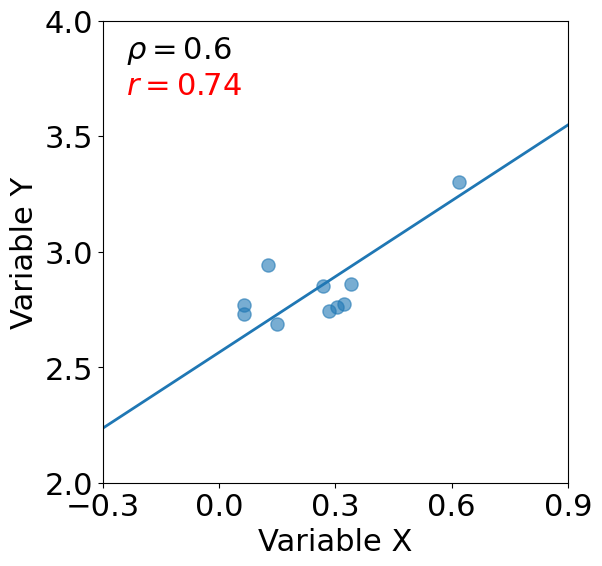

In [229]:
# 10 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

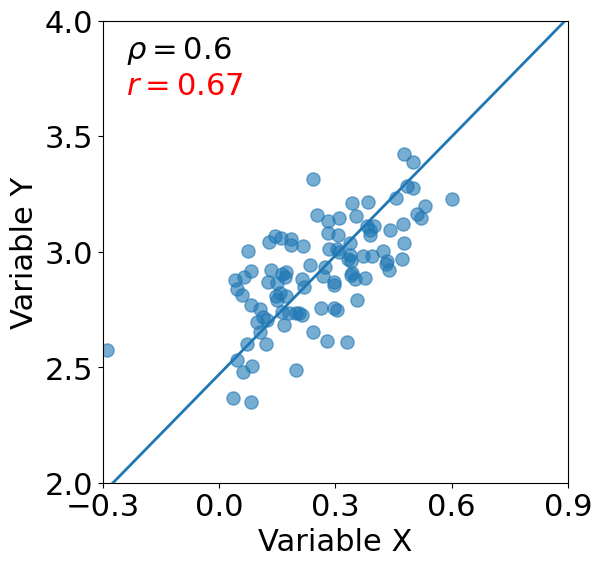

In [230]:
# 100 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

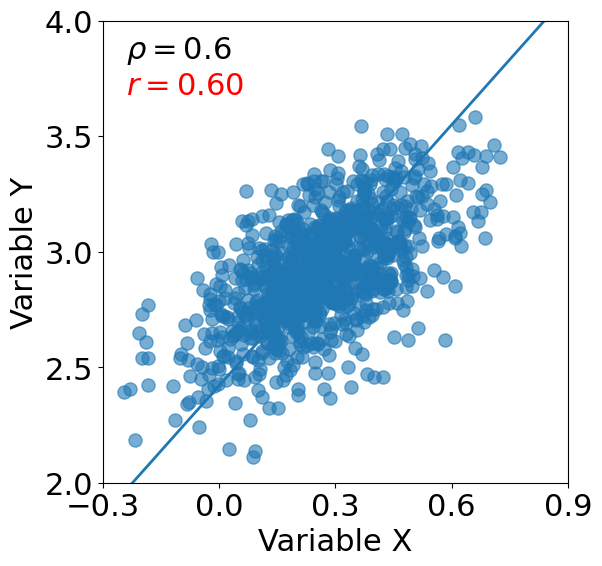

In [231]:
# 1000 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=1000)
plot_scatter_with_tls(x, y, rho=rho)

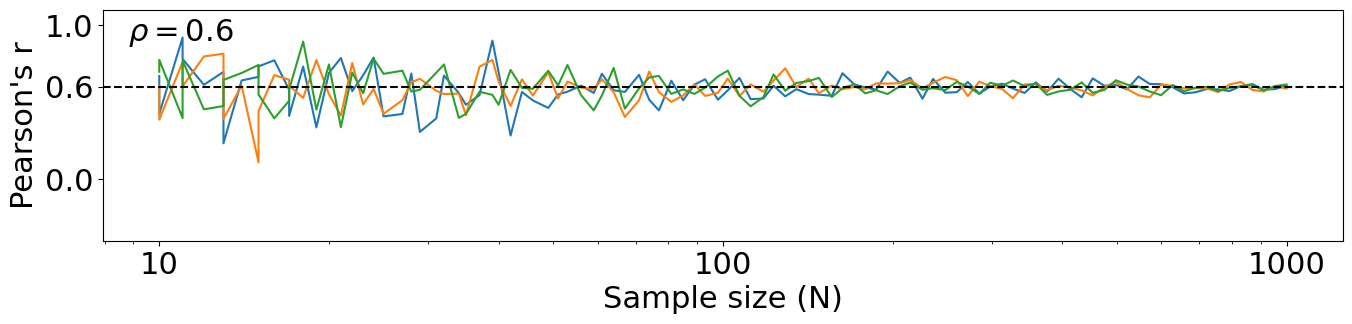

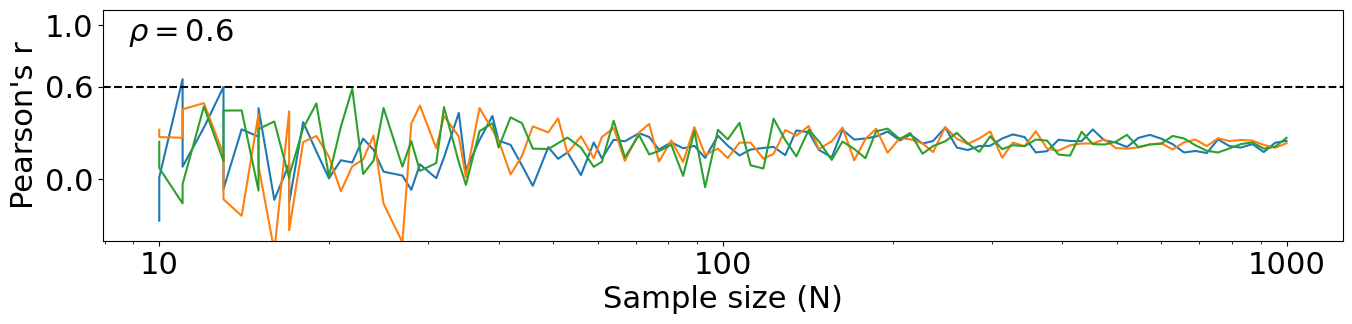

In [233]:
plot_r_vs_sample_size(mu_x, mu_y, var_x, var_y, rho)

## NOISE

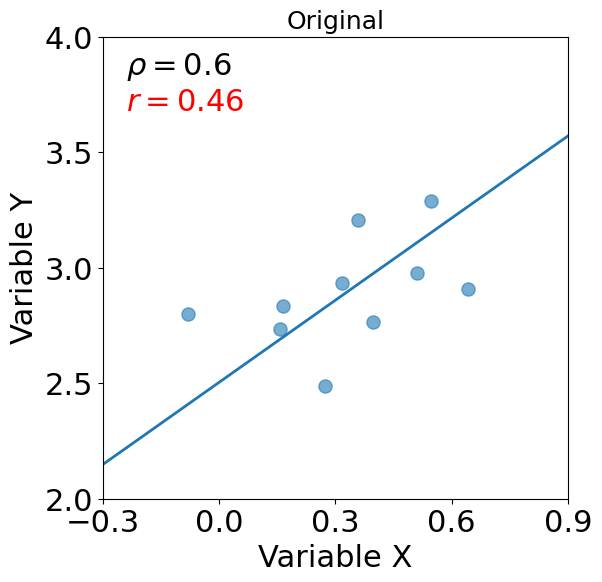

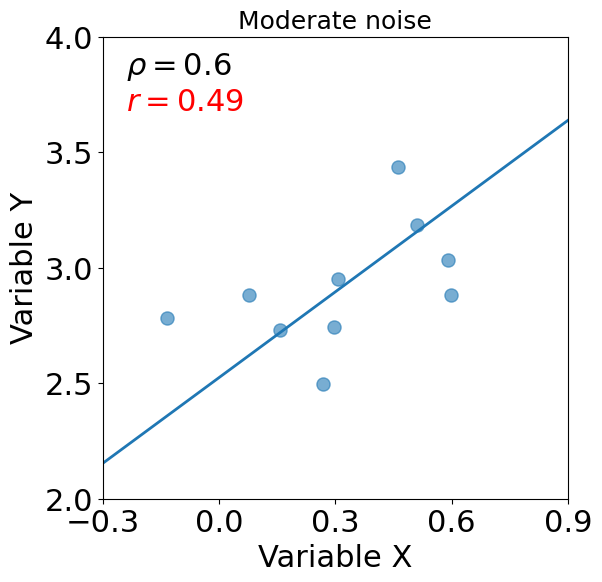

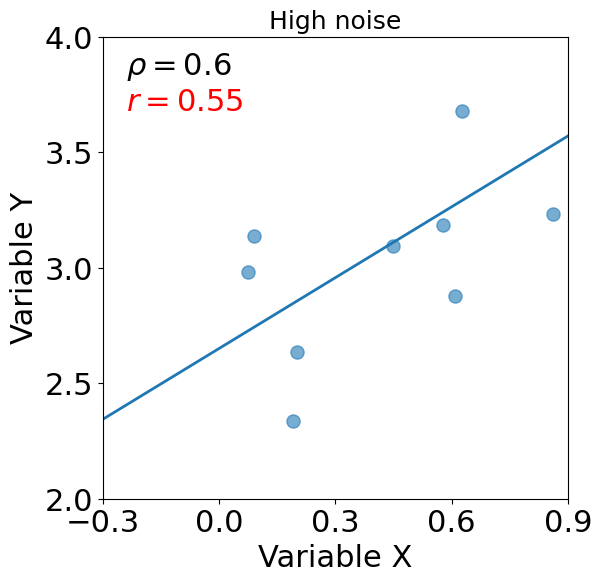

In [242]:
# Parameters
var_x, var_y, noise_var = 0.06, 0.06, 0.06

# Base data once
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10, rng=global_rng)

# Plot: original + different noise multipliers
for m, title in [(0.0, 'Original'), (0.1, 'Moderate noise'), (1.0, 'High noise')]:
    if m == 0.0:
        x_plot, y_plot = x, y
    else:
        x_plot, y_plot = add_gaussian_noise(x, y, noise_var, m=m, rng=global_rng)

    ax = plot_scatter_with_tls(x_plot, y_plot, rho=rho)
    ax.set_title(title, fontsize=18)
    plt.show()

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_42655/3763507036.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-0.1,2.1)


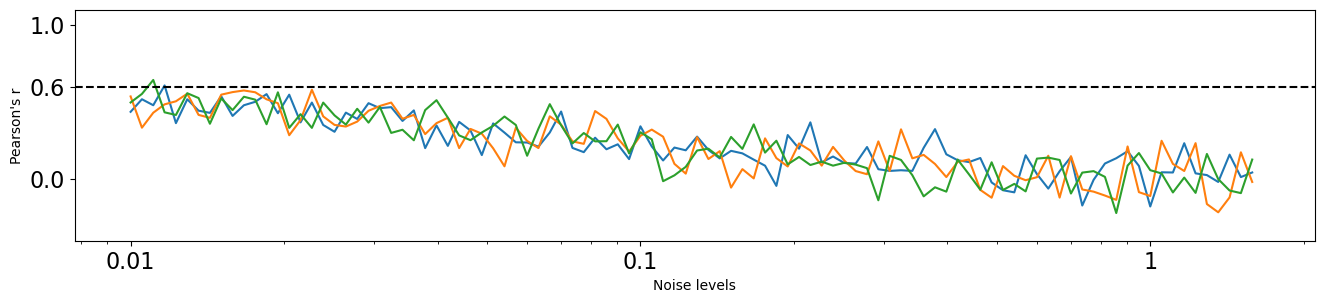

In [ ]:
# Define a range of noise levels
noise_levels = np.logspace(-2, 0.2, num=100)
n_traces = 3  # number of replicate traces
N = 100

# Preallocate array to hold Pearson r values
results = np.empty((n_traces, noise_levels.size))

# Simulate and compute Pearson r for each trace and sample size
for t in range(n_traces):
    for idx, noise_var in enumerate(noise_levels):
        data = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=N)
        noise = np.random.normal(0, np.sqrt(noise_var), size=data.shape)
        noisy_data = data + noise
        r, _ = pearsonr(noisy_data[:, 0], noisy_data[:, 1])
        results[t, idx] = r

plt.figure(figsize=(16, 3))
for t in range(n_traces):
    plt.plot(noise_levels, results[t])# label=f'Simulation {t+1}')
plt.axhline(0.6, color='black', ls='--', label = 'True R')
plt.xlabel('Noise levels')
plt.ylabel("Pearson's r")
plt.xticks(size=16)
plt.yticks([0, 0.6, 1], size=16)
plt.xscale('log')
plt.xlim(-0.1,2.1)
plt.ylim(-0.4,1.1)
ax = plt.gca()
# Use %g so you get regular decimal notation (e.g. 0.1, 1, 10) instead of 1e-1, 1e0, 1e1
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

# And adjust tick label sizes
ax.tick_params(axis='x', labelsize=16)
#ax.tick_params(axis='y', labelsize=16)
#plt.legend(fontsize=14)
plt.show()

# MEANS

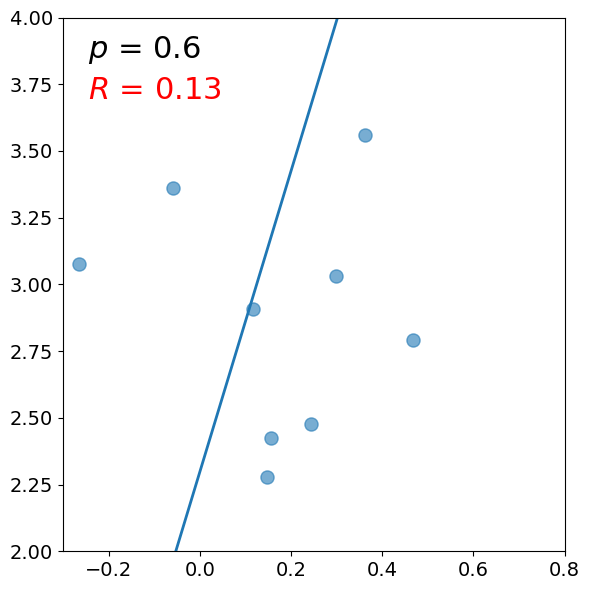

In [ ]:
# --- 10 THRESHOLDS ---
m = 1
n_points = 10

x_sum = []
y_sum = []
for i in range(10):
    x_noisy = [x + np.random.normal(0, np.sqrt(noise_var*m), n_points)]
    y_noisy = [y + np.random.normal(0, np.sqrt(noise_var*m), n_points)]
    x_sum += x_noisy
    y_sum += y_noisy
    
x_mean = np.mean(x_sum, axis=0)
y_mean = np.mean(y_sum, axis=0)
    
slope_n, intercept_n = tls_regression(x_mean, y_mean)
r_value, p_value = pearsonr(x_mean, y_mean)

plt.figure(figsize=(6, 6))
plt.scatter(x_mean, y_mean, alpha=.6, s=90)
x_line_n = np.linspace(-3, 3, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2, label='TLS fit (noisy)')
plt.text(0.05, 0.97, f'$p$ = 0.6',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'$R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.xlim(-.3, .8)
plt.ylim(2, 4)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

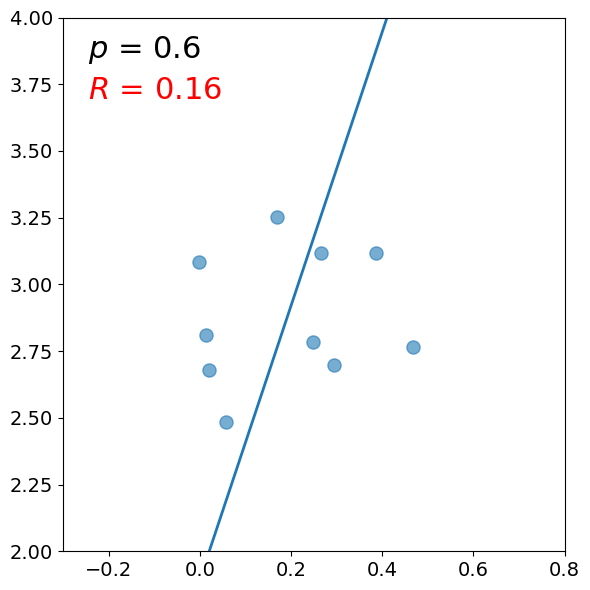

In [ ]:
# --- 100 THRESHOLDS ---
m = 0.5
n_points = 10

x_sum = []
y_sum = []
for i in range(100):
    x_noisy = [x + np.random.normal(0, np.sqrt(noise_var*m), n_points)]
    y_noisy = [y + np.random.normal(0, np.sqrt(noise_var*m), n_points)]
    x_sum += x_noisy
    y_sum += y_noisy
    
x_mean = np.mean(x_sum, axis=0)
y_mean = np.mean(y_sum, axis=0)
    
slope_n, intercept_n = tls_regression(x_mean, y_mean)
r_value, p_value = pearsonr(x_mean, y_mean)

plt.figure(figsize=(6, 6))
plt.scatter(x_mean, y_mean, alpha=.6, s=90)
x_line_n = np.linspace(-3, 3, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2, label='TLS fit (noisy)')
plt.text(0.05, 0.97, f'$p$ = 0.6',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'$R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.xlim(-.3, .8)
plt.ylim(2, 4)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

In [ ]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_i, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Apply the extrapolation formula for multiple measurements (2 halves)
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [ ]:
def simulate_estimators(n_points=100, m=1):
    # --- 1) simulate ---
    mu_x, mu_y = 0.25, 2.9
    var_x, var_y, noise_var = 0.0254, 0.0558, 0.02
    rho = 0.6
    cov_xy = rho * np.sqrt(var_x * var_y)
    cov_matrix = np.array([[var_x, cov_xy],
                           [cov_xy, var_y]])

    num_thresholds = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100])
    n_traces = 3
    results_raw      = np.empty((n_traces, num_thresholds.size))
    results_unbiased = np.empty((n_traces, num_thresholds.size))

    for t in range(n_traces):
        x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T
        x_reps, y_reps = [], []

        for idx, thresh in enumerate(num_thresholds):
            # add needed replicates
            for _ in range(thresh - len(x_reps)):
                x_reps.append(x + np.random.normal(0, np.sqrt(noise_var*m), size=n_points))
                y_reps.append(y + np.random.normal(0, np.sqrt(noise_var*m), size=n_points))

            x_stack = np.vstack(x_reps)
            y_stack = np.vstack(y_reps)

            # raw Pearson r
            raw_r, _ = pearsonr(x_stack.mean(axis=0), y_stack.mean(axis=0))

            # reliabilities via split-half
            x_df = pd.DataFrame(x_stack.T)
            y_df = pd.DataFrame(y_stack.T)
            rel_x = compute_noise_ceiling_splitHalf(x_df)
            rel_y = compute_noise_ceiling_splitHalf(y_df)
            noise_ceiling = np.sqrt(rel_x * rel_y)

            results_raw[t, idx]      = raw_r
            results_unbiased[t, idx] = raw_r / noise_ceiling

    # grab the first three default colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # --- 2) combined plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        c = colors[t % len(colors)]
        if t == 0:
            ax.plot(num_thresholds, results_raw[t],
                    linestyle='--', color=c, alpha=0.5,
                    label='Raw')
            ax.plot(num_thresholds, results_unbiased[t],
                    linestyle='-', color=c, alpha=1.0,
                    label='Unbiased')
        else:
            ax.plot(num_thresholds, results_raw[t],
                    linestyle='--', color=c, alpha=0.5)
            ax.plot(num_thresholds, results_unbiased[t],
                    linestyle='-', color=c, alpha=1.0)

    ax.axhline(0.6, color='k', linestyle='--')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('R', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.legend(loc='lower right', fontsize=14, frameon=False)
    plt.show()

    # --- 3) raw-only plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        ax.plot(num_thresholds, results_raw[t],
                linestyle='-', color=colors[t % len(colors)], alpha=1.0)
    ax.axhline(0.6, color='k', linestyle='--')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('Raw R', fontsize=16)
    ax.tick_params(labelsize=16)
    plt.show()

    # --- 4) unbiased-only plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        ax.plot(num_thresholds, results_unbiased[t],
                linestyle='-', color=colors[t % len(colors)], alpha=1.0)
    ax.axhline(0.6, color='k', linestyle='--')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('Unbiased R', fontsize=16)
    ax.tick_params(labelsize=16)
    plt.show()


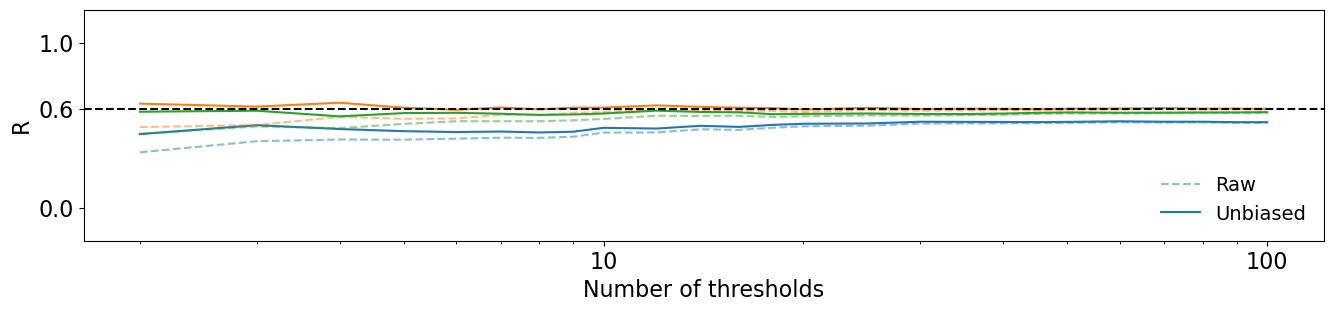

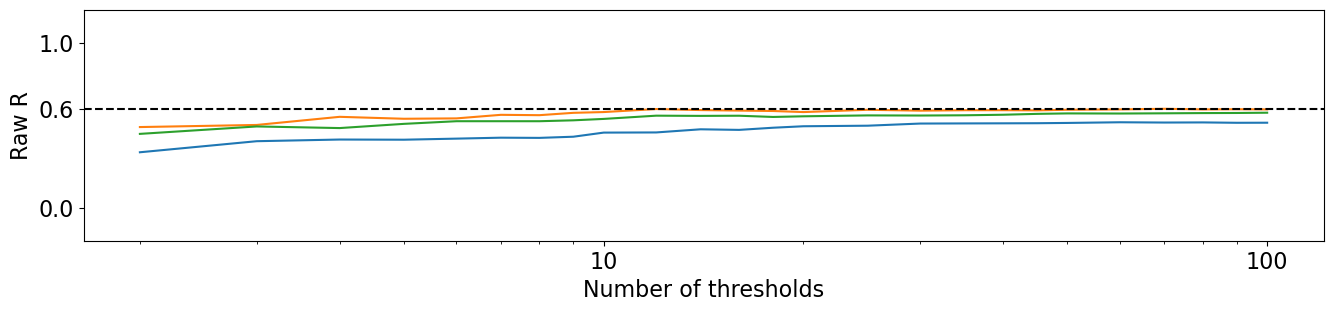

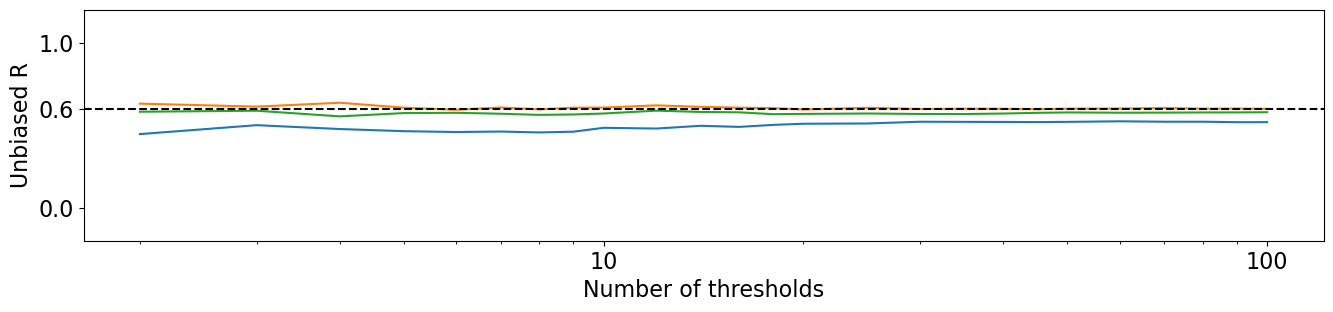

In [ ]:
simulate_estimators(n_points=200, m=1)

In [ ]:
def simulate_estimators(n_points=100, m=1):
    # --- 1) simulate ---
    mu_x, mu_y = 0.25, 2.9
    var_x, var_y, noise_var = 0.0254, 0.0558, 0.02
    rho = 0.6
    cov_xy = rho * np.sqrt(var_x * var_y)
    cov_matrix = np.array([[var_x, cov_xy],
                           [cov_xy, var_y]])

    num_thresholds = np.array([2,3,4,5,6,7,8,9,10])
    n_traces = 3
    results_raw      = np.empty((n_traces, num_thresholds.size))
    results_unbiased = np.empty((n_traces, num_thresholds.size))

    for t in range(n_traces):
        x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T
        x_reps, y_reps = [], []

        for idx, thresh in enumerate(num_thresholds):
            # add needed replicates
            for _ in range(thresh - len(x_reps)):
                x_reps.append(x + np.random.normal(0, np.sqrt(noise_var*m), size=n_points))
                y_reps.append(y + np.random.normal(0, np.sqrt(noise_var*m), size=n_points))

            x_stack = np.vstack(x_reps)
            y_stack = np.vstack(y_reps)

            # raw Pearson r
            raw_r, _ = pearsonr(x_stack.mean(axis=0), y_stack.mean(axis=0))

            # reliabilities via split-half
            x_df = pd.DataFrame(x_stack.T)
            y_df = pd.DataFrame(y_stack.T)
            rel_x = compute_noise_ceiling_splitHalf(x_df)
            rel_y = compute_noise_ceiling_splitHalf(y_df)
            noise_ceiling = np.sqrt(rel_x * rel_y)

            results_raw[t, idx]      = raw_r
            results_unbiased[t, idx] = raw_r / noise_ceiling

    # grab the first three default colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # --- 2) combined plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        c = colors[t % len(colors)]
        if t == 0:
            ax.plot(num_thresholds, results_raw[t],
                    linestyle='--', color=c, alpha=0.5,
                    label='Raw')
            ax.plot(num_thresholds, results_unbiased[t],
                    linestyle='-', color=c, alpha=1.0,
                    label='Unbiased')
        else:
            ax.plot(num_thresholds, results_raw[t],
                    linestyle='--', color=c, alpha=0.5)
            ax.plot(num_thresholds, results_unbiased[t],
                    linestyle='-', color=c, alpha=1.0)

    ax.axhline(0.6, color='k', linestyle='--')
    #ax.set_xscale('log')
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('R', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.legend(loc='lower right', fontsize=14, frameon=False)
    plt.show()

    # --- 3) raw-only plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        ax.plot(num_thresholds, results_raw[t],
                linestyle='-', color=colors[t % len(colors)], alpha=1.0)
    ax.axhline(0.6, color='k', linestyle='--')
   # ax.set_xscale('log')
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('Raw R', fontsize=16)
    ax.tick_params(labelsize=16)
    plt.show()

    # --- 4) unbiased-only plot ---
    fig, ax = plt.subplots(figsize=(16, 3))
    for t in range(n_traces):
        ax.plot(num_thresholds, results_unbiased[t],
                linestyle='-', color=colors[t % len(colors)], alpha=1.0)
    ax.axhline(0.6, color='k', linestyle='--')
  #  ax.set_xscale('log')
  #  ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 0.6, 1])
    ax.set_xlabel('Number of thresholds', fontsize=16)
    ax.set_ylabel('Unbiased R', fontsize=16)
    ax.tick_params(labelsize=16)
    plt.show()


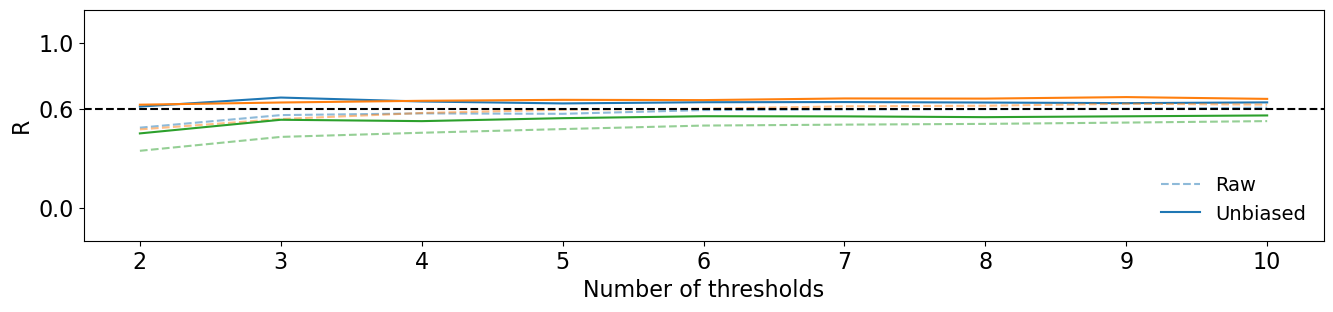

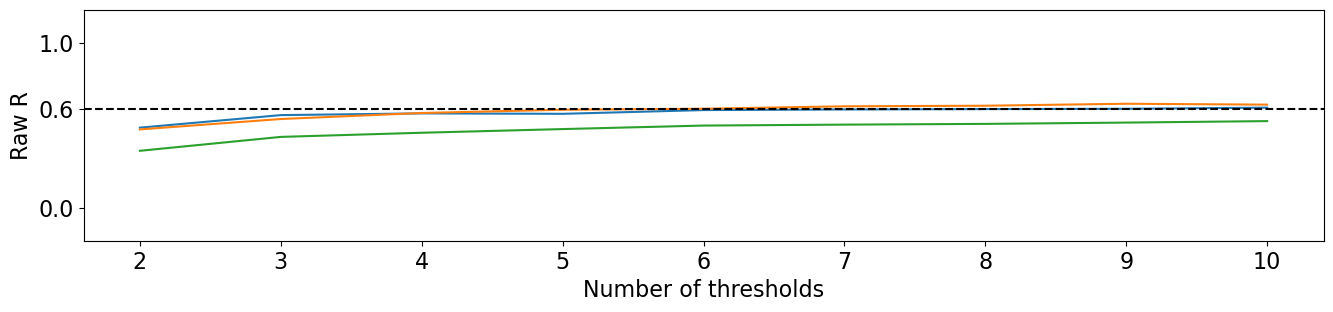

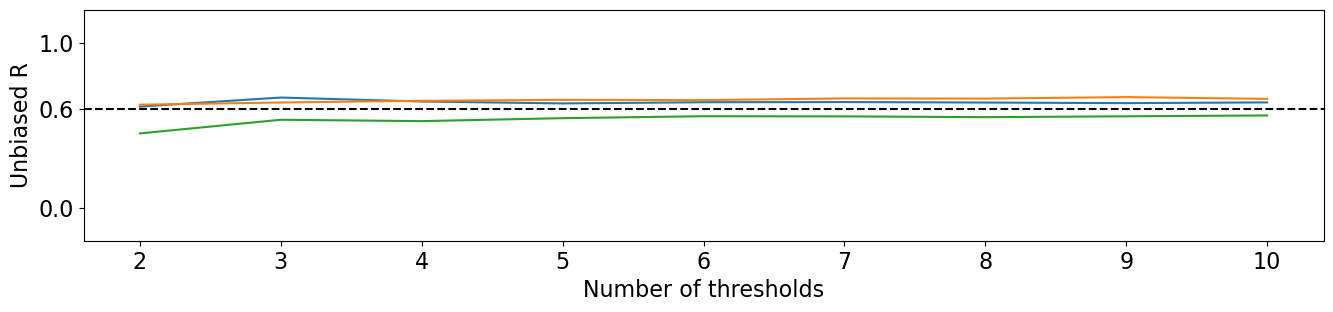

In [ ]:
simulate_estimators(n_points=200, m=1)

# ESTIMATOR SELECTION

In [ ]:
import numpy as np

def choose_best_estimator(n_samples, n_meas, rho,
                          obs_var_x, meas_var_x,
                          obs_var_y, meas_var_y):
    """
    Decide whether raw or R-ceiling corrected Pearson r
    has lower RMSE, accounting for different variances in X and Y.

    Parameters
    ----------
    n_samples : int
        Number of observers (sample size).
    n_meas : int
        Number of repeated measurements per observer.
    rho : float
        True correlation (–1 to 1).
    obs_var_x : float
        Variance of true X thresholds across observers.
    meas_var_x : float
        Measurement noise variance for X.
    obs_var_y : float
        Variance of true Y thresholds across observers.
    meas_var_y : float
        Measurement noise variance for Y.

    Returns
    -------
    choice : str
        'raw' or 'r-ceiling'
    rmse_raw : float
    rmse_rceil : float
    """
    # reliability for X and Y
    Rx = obs_var_x / (obs_var_x + meas_var_x / n_meas)
    Ry = obs_var_y / (obs_var_y + meas_var_y / n_meas)
    lam = np.sqrt(Rx * Ry)

    # approximate sampling variance of Pearson r
    var_r = (1 - rho**2)**2 / (n_samples - 1)

    # approximate RMSEs
    rmse_raw = np.sqrt(var_r + (rho * (1 - lam))**2)
    rmse_rceil = np.sqrt(var_r / lam**2)

    choice = 'raw' if rmse_raw < rmse_rceil else 'r-ceiling'
    return choice, rmse_raw, rmse_rceil

In [ ]:
choice, rmse_raw, rmse_rc = choose_best_estimator(
    n_samples=30,
    n_meas=2,
    rho=0.6,
    obs_var_x=0.0254,
    meas_var_x=0.0141*10,
    obs_var_y=0.056,
    meas_var_y=0.0157*10
)
print(f"Best estimator: {choice}")
print(f"RMSE raw = {rmse_raw:.3f}, RMSE r-ceiling = {rmse_rc:.3f}")

Best estimator: r-ceiling
RMSE raw = 0.418, RMSE r-ceiling = 0.358


# --------------------------------------------------------------------------
# ------------------------------- ARCHIVE -------------------------------
# --------------------------------------------------------------------------

# RELIABILITIES

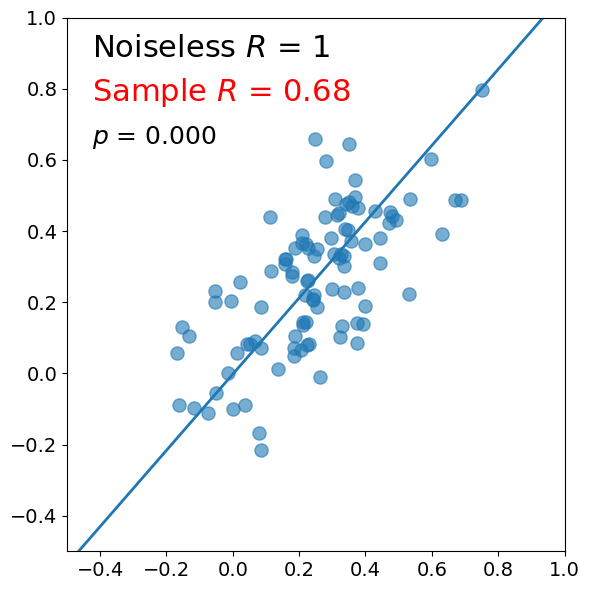

In [ ]:
# Parameters: you can change these to your desired values
mu_x, mu_y = 0.25, 0.25
var_x, var_y = 0.025, 0.025
noise_std = np.sqrt(.014)
n_points = 100
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=0.6)
x_line_n = np.linspace(-3, 3, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2, label='TLS fit (noisy)')
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(-.5, 1)
plt.ylim(-.5, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

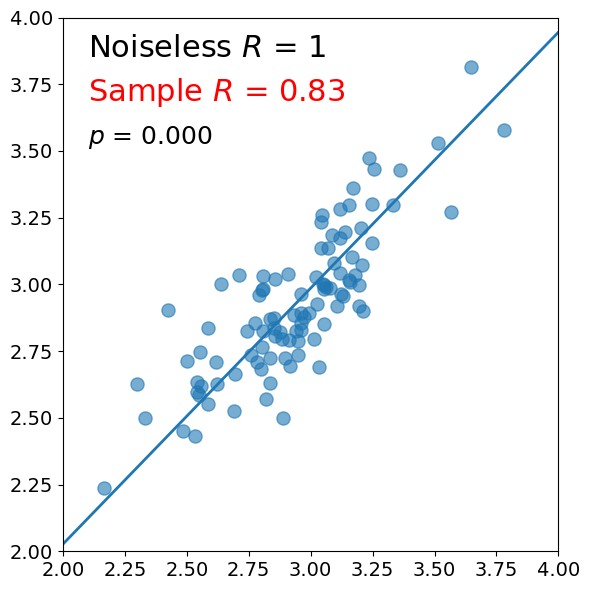

In [ ]:
# Parameters
mu_x, mu_y = 2.9, 2.9
var_x, var_y = 0.06, 0.06
noise_std = np.sqrt(.016)
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=.6)
x_line_n = np.linspace(-3, 5, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2)
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(2, 4)
plt.ylim(2, 4)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

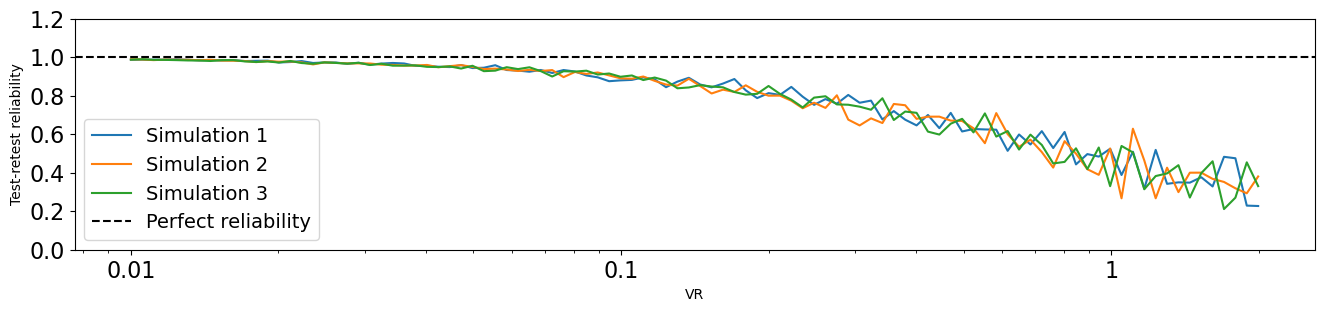

In [ ]:
# Parameters
mu_x, mu_y = 2, 2
var_x, var_y = 1, 1
rho = 1
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])
N = 100
data = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=N)

# Define a range of noise levels
noise_levels = np.logspace(-2, 0.3, num=100)
n_traces = 3  # number of replicate traces

# Preallocate array to hold Pearson r values
results = np.empty((n_traces, noise_levels.size))

# Simulate and compute Pearson r for each trace and sample size
for t in range(n_traces):
    for idx, noise_var in enumerate(noise_levels):
        noise = np.random.normal(0, np.sqrt(noise_var), size=data.shape)
        noisy_data = data + noise
        r, _ = pearsonr(noisy_data[:, 0], noisy_data[:, 1])
        results[t, idx] = r

plt.figure(figsize=(16, 3))
for t in range(n_traces):
    plt.plot(noise_levels, results[t], label=f'Simulation {t+1}')
plt.axhline(1, color='black', ls='--', label = 'Perfect reliability')
plt.xlabel('VR')
plt.ylabel("Test-retest reliability")
plt.xticks(size=16)
plt.yticks(size=16)
#plt.xlim(0,100)
plt.ylim(0,1.2)
plt.xscale('log')
ax = plt.gca()
# Use %g so you get regular decimal notation (e.g. 0.1, 1, 10) instead of 1e-1, 1e0, 1e1
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

# And adjust tick label sizes
ax.tick_params(axis='x', labelsize=16)
plt.legend(fontsize=14)
plt.show()